# Robust Optimization in Portfolio Management
Author: Xiaochen Wang, Chao Wang

Model:

$$min\;\;w^T\Sigma w $$
$$s.t.\; \overline{r}^T w + \rho \|(\Sigma^{-\frac{1}{2}})^T w\|_2 \geq \beta$$
$$w_i \leq t,\;\forall i=1,...,n$$
$$\sum w_i = 1$$
$$w_1,...,w_n \geq 0$$


In [ ]:
%pip install gurobipy yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.0 MB/s 
     |████████████████████████████████| 62 kB 557 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf

stocks = [
    'JNJ', 'UNH', # healthcare
    'JPM', 'C', # financial
    'DAL', 'ALGT', # industrial
    'AAPL', 'META', # info tech
    'TGT', 'BBY' # Consumer Discretionary
]
data = yf.download(stocks, start = '2019-01-01', end = '2020-04-01')
data.shape

[*********************100%***********************]  10 of 10 completed


(314, 60)

In [ ]:
data.Close.isna().sum()

AAPL    0
ALGT    0
BBY     0
C       0
DAL     0
JNJ     0
JPM     0
META    0
TGT     0
UNH     0
dtype: int64

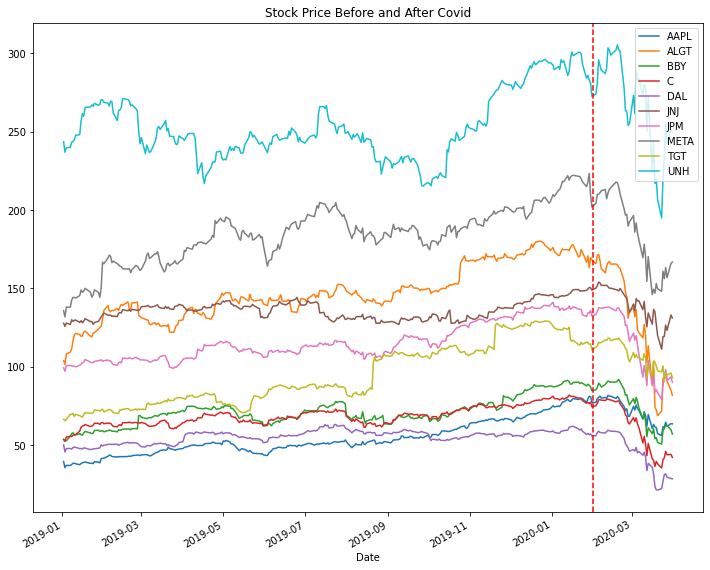

In [ ]:
import matplotlib.pyplot as plt

data.Close.plot(figsize=(12, 10))
plt.title('Stock Price Before and After Covid')
plt.axvline(x = '2020-02-01', color = 'r', linestyle = '--')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime

covid_date = datetime.strptime('2020-01-01', '%Y-%M-%d')

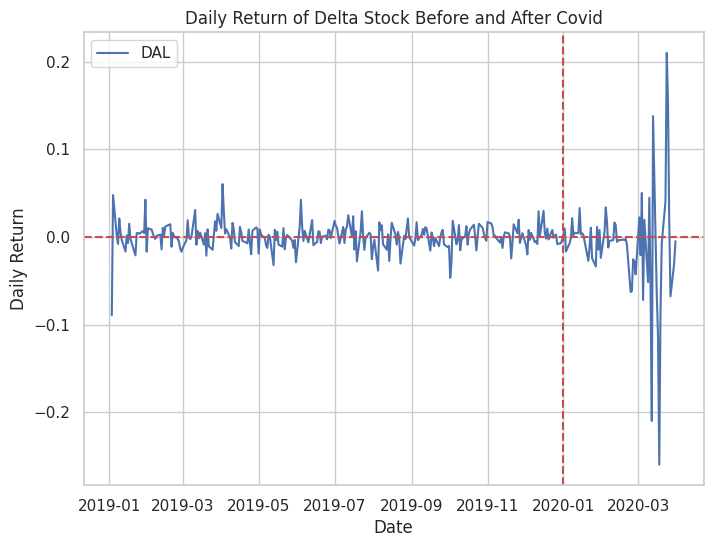

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

data_close = data['Close']

r = ((data_close - data_close.shift())/data_close.shift()).iloc[1:]

plt.figure(figsize=(8, 6), dpi = 100)

sns.lineplot(data=r[['DAL']])
plt.title('Daily Return of Delta Stock Before and After Covid')
plt.axvline(x = covid_date, color = 'r', linestyle = '--')
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.ylabel('Daily Return')
plt.xlabel('Date')
plt.show()

In [ ]:
before_r = r[r.index <= covid_date]
after_r = r[r.index > covid_date]

In [ ]:
weight_bl = [
 0,
 0.153,
 0.038,
 0,
 0.016,
 0.300,
 0.237,
 0.048,
 0.070,
 0.138]

In [ ]:
weight_ro = [
 0.133,
 0.083,
 0.145,
 0.125,
 0.101,
 0.037,
 0.089,
 0.107,
 0.119,
 0.061
]

In [ ]:
import pandas as pd

return_summary = pd.DataFrame([list(before_r.mean(axis = 0)), 
                               list(before_r.std(axis = 0)),
                               list(before_r.mean(axis = 0)/before_r.std(axis = 0)), 
                               weight_bl, 
                               weight_ro]).T
return_summary.columns = [['mean', 'std', 'Sharpe_Ratio_Before_Covid', 'weight_baseline', 'weight_robust']]
return_summary['stock'] = stocks
return_summary

,mean,std,Sharpe_Ratio_Before_Covid,weight_baseline,weight_robust,stock
0,0.002612,0.016525,0.158036,0.000,0.133,JNJ
1,0.002175,0.015404,0.141191,0.153,0.083,UNH
2,0.002194,0.021375,0.102643,0.038,0.145,JPM
3,0.001713,0.015293,0.112009,0.000,0.125,C
4,0.000725,0.014636,0.049504,0.016,0.101,DAL
5,0.000583,0.010372,0.056172,0.300,0.037,ALGT
6,0.001422,0.011851,0.119964,0.237,0.089,AAPL
7,0.001801,0.017471,0.103105,0.048,0.107,META
8,0.002829,0.021001,0.134694,0.070,0.119,TGT
9,0.000876,0.015858,0.055226,0.138,0.061,BBY


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


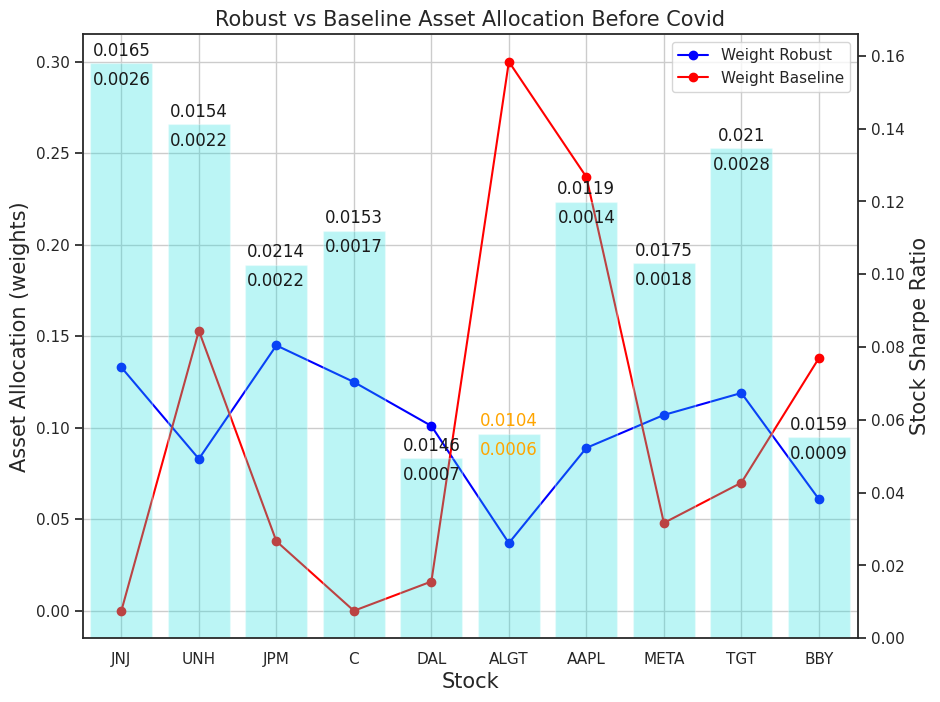

In [ ]:
plt.figure(figsize=(10, 8), dpi = 100)
plt.rcParams.update({'font.size': 12})
sns.set_style("whitegrid")

plt.plot(return_summary['weight_robust'].values.flatten(), marker = 'o', label = 'Weight Robust', color='blue')
plt.plot(return_summary['weight_baseline'].values.flatten(), marker = 'o', label = 'Weight Baseline', color='red')
plt.legend()
plt.xlabel("Stock", fontsize=15)
plt.ylabel('Asset Allocation (weights)', fontsize=15)

sns.set_style("white")
ax2 = plt.twinx()

splot = sns.barplot(return_summary['stock'].values.flatten(), return_summary['Sharpe_Ratio_Before_Covid'].values.flatten(), ax=ax2, alpha = 0.3, color='cyan')
for stock, p, std, mean in zip(stocks, splot.patches, return_summary['std'].values.flatten(), return_summary['mean'].values.flatten()):
    c = 'orange' if stock == 'ALGT' else 'k'
    splot.annotate(format(round(std, 4)),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 9), textcoords='offset points', color = c, alpha = 1)
    
    splot.annotate(format(round(mean, 4)),
                   (p.get_x() + p.get_width() / 2., p.get_height()-0.008),
                   ha='center', va='center', xytext=(0, 9), textcoords='offset points', color = c, alpha = 1)

plt.ylabel('Stock Sharpe Ratio', fontsize=15)

plt.title('Robust vs Baseline Asset Allocation Before Covid', fontsize=15)
plt.xlabel('Stock')

plt.show()

In [ ]:
import pandas as pd

return_summary = pd.DataFrame([list(before_r.mean(axis = 0)), before_r.std(axis = 0), list(before_r.mean(axis = 0)/before_r.std(axis = 0))]).T
return_summary.columns = [['Return', 'Std', 'Sharpe_Ratio']]
return_summary

,Return,Std,Sharpe_Ratio
0,0.002612,0.016525,0.158036
1,0.002175,0.015404,0.141191
2,0.002194,0.021375,0.102643
3,0.001713,0.015293,0.112009
4,0.000725,0.014636,0.049504
5,0.000583,0.010372,0.056172
6,0.001422,0.011851,0.119964
7,0.001801,0.017471,0.103105
8,0.002829,0.021001,0.134694
9,0.000876,0.015858,0.055226


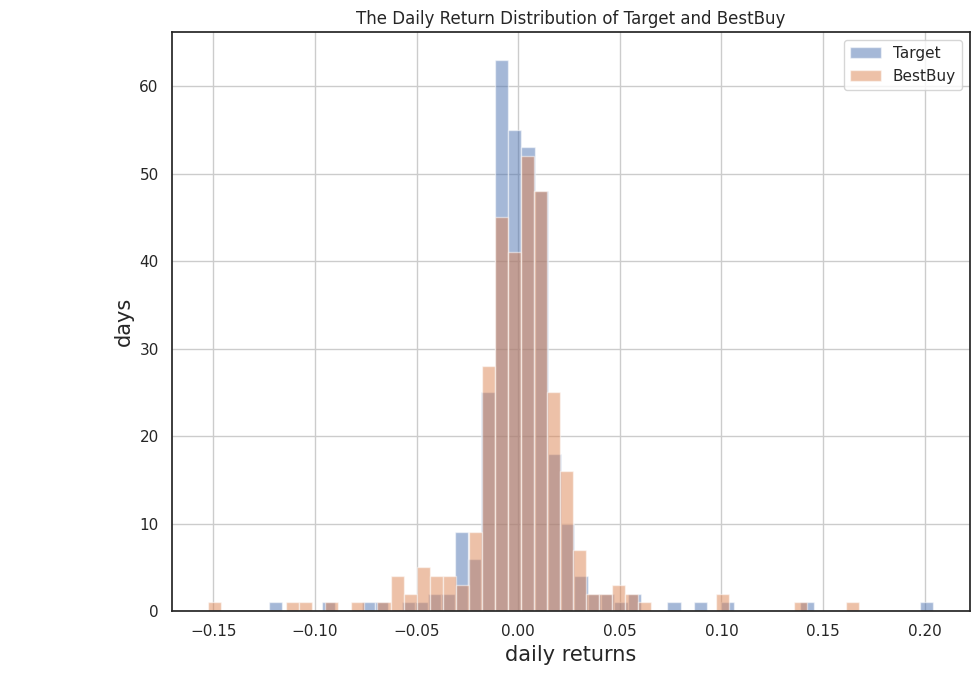

In [ ]:
plt.figure(figsize=(10, 7), dpi = 100)
plt.rcParams.update({'font.size': 15})

r['TGT'].hist(bins = 50, alpha = 0.5, label = 'Target')
r['BBY'].hist(bins = 50, alpha = 0.5, label = 'BestBuy')
plt.xlabel('daily returns', size = 15)
plt.ylabel('days', size = 15)
plt.legend()
plt.title('The Daily Return Distribution of Target and BestBuy')
plt.annotate('2022-05-18', (-0.25, 22), size = 15)
plt.arrow(x = -0.22, y = 20, dx = -0.02, dy = -15, color = 'red', head_length = 3, head_width = 0.01)
plt.tight_layout()

In [ ]:
r['TGT'].argmin()

363

In [ ]:
r.iloc[363]

AAL    -0.052189
AAPL   -0.056419
BBY    -0.105089
C      -0.033888
DAL    -0.034627
JNJ    -0.018566
JPM    -0.017106
MSFT   -0.047748
PFE    -0.018309
TGT    -0.249303
Name: 2022-05-18 00:00:00, dtype: float64

## Minimize risk by solving QP model

In [ ]:
import numpy as np

closes = np.transpose(np.array(data.Close)) # matrix of daily closing prices
absdiff = np.diff(closes)                   # change in closing price each day
reldiff = np.divide(absdiff, closes[:,:-1]) # relative change in daily closing price
delta = np.mean(reldiff, axis=1)            # mean price change
sigma = np.cov(reldiff)                     # covariance (standard deviations)
inv_sigma = linalg.inv(sigma)
std = np.std(reldiff, axis=1)               # standard deviation

In [ ]:
linalg.norm(delta)

0.001028043942822041

In [ ]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

def train_baseline(w_threshold, required_return):
  # Create an empty model
  m = gp.Model('portfolio')

  # Add matrix variable for the stocks
  x = m.addMVar(len(stocks))

  # Objective is to minimize risk (squared).  This is modeled using the
  # covariance matrix, which measures the historical correlation between stocks
  portfolio_risk = x @ sigma @ x
  m.setObjective(portfolio_risk, GRB.MINIMIZE)

  # Fix budget with a constraint
  m.addConstr(x.sum() == 1, 'total weight')
  m.addConstr(x[1:10] >= 0, 'long only')
  m.addConstr(delta @ x >= required_return, 'long only')
  m.addConstr(x[1:10] <= w_threshold, 'max weight')

  # Verify model formulation
  m.write('portfolio_selection_optimization.lp')

  # Optimize model to find the minimum risk portfolio
  m.optimize()

  return m

def train_robust(w_threshold, required_return, rho):
  # Create an empty model
  m = gp.Model('portfolio')

  # Add matrix variable for the stocks
  x = m.addMVar(len(stocks))

  # Objective is to minimize risk (squared).  This is modeled using the
  # covariance matrix, which measures the historical correlation between stocks
  portfolio_risk = x @ sigma @ x
  m.setObjective(portfolio_risk, GRB.MINIMIZE)

  # Fix budget with a constraint
  m.addConstr(x.sum() == 1, 'total weight')
  m.addConstr(x[1:10] >= 0, 'long only')
  m.addConstr(rho*rho * (x @ inv_sigma @ x) <= (delta @ x - required_return)*(delta @ x - required_return), 'long only')
  m.addConstr(delta @ x - required_return >= 0, "non-negative")
  m.addConstr(x[1:10] <= w_threshold, 'max weight')

  # Verify model formulation
  m.write('portfolio_selection_optimization.lp')

  # Optimize model to find the minimum risk portfolio
  m.optimize()

  return m

required_return = 0.0004
w_threshold = 0.4
rho = 0.0001
model_base = train_baseline(w_threshold, required_return)
model_robust = train_robust(w_threshold, required_return, rho)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 20 rows, 10 columns and 38 nonzeros
Model fingerprint: 0xf35eb54f
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-04, 1e+00]
Presolve removed 18 rows and 0 columns
Presolve time: 0.03s
Presolved: 2 rows, 10 columns, 20 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 5.500e+01
 Factor NZ  : 6.600e+01
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   

In [ ]:
rho*rho * (x.X @ inv_sigma @ x.X)

5.28673888294106e-07

In [ ]:
(delta @ x.X - required_return)*(delta @ x.X - required_return)

7.457836828732745e-08

In [ ]:
delta @ x.X - required_return

-0.00027309040314029245

## Display minimum risk portfolio using Pandas

In [ ]:
import pandas as pd
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=stocks + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
JNJ,0.180839
PFE,0.094822
JPM,0.127236
C,0.102477
DAL,0.152025
AAL,0.025549
MSFT,0.089156
AAPL,0.085210
TGT,0.034726
BBY,0.107960


## Compute the efficient frontier
Solve the QP parametrically to find the lowest risk portfolio for different expected returns.

In [ ]:
# Create an expression representing the expected return for the portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 11 rows, 10 columns and 29 nonzeros
Model fingerprint: 0xcb3325c9
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 1e+00]
Presolve removed 9 rows and 0 columns
Presolve time: 0.01s
Presolved: 2 rows, 10 columns, 20 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 5.500e+01
 Factor NZ  : 6.600e+01
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1

In [ ]:
frontier

array([[ 1.89955238e-02,  1.79551181e-02,  1.71766991e-02,
         1.64141666e-02,  1.56704129e-02,  1.49480164e-02,
         1.42500857e-02,  1.35804818e-02,  1.29436074e-02,
         1.23445088e-02,  1.17887527e-02,  1.12830211e-02,
         1.08344078e-02,  1.04463301e-02,  1.01175687e-02,
         9.84719735e-03,  9.63325019e-03,  9.47934024e-03,
         9.37982554e-03,  9.31707386e-03,  9.29142846e-03,
         9.38681430e-03,  1.01473369e-02,  1.21749234e-02,
         1.68670626e-02],
       [-3.41029416e-04, -3.05883295e-04, -2.70737174e-04,
        -2.35591054e-04, -2.00444933e-04, -1.65298812e-04,
        -1.30152692e-04, -9.50065710e-05, -5.98604503e-05,
        -2.47143296e-05,  1.04317911e-05,  4.55779118e-05,
         8.07240325e-05,  1.15870153e-04,  1.51016274e-04,
         1.86162395e-04,  2.21308515e-04,  2.56454636e-04,
         2.91600757e-04,  3.26746877e-04,  3.61892998e-04,
         3.97039119e-04,  4.32185239e-04,  4.67331360e-04,
         5.02477481e-04]])

## Plot results
Use the matplot library to plot the optimized solutions, along with the individual stocks:

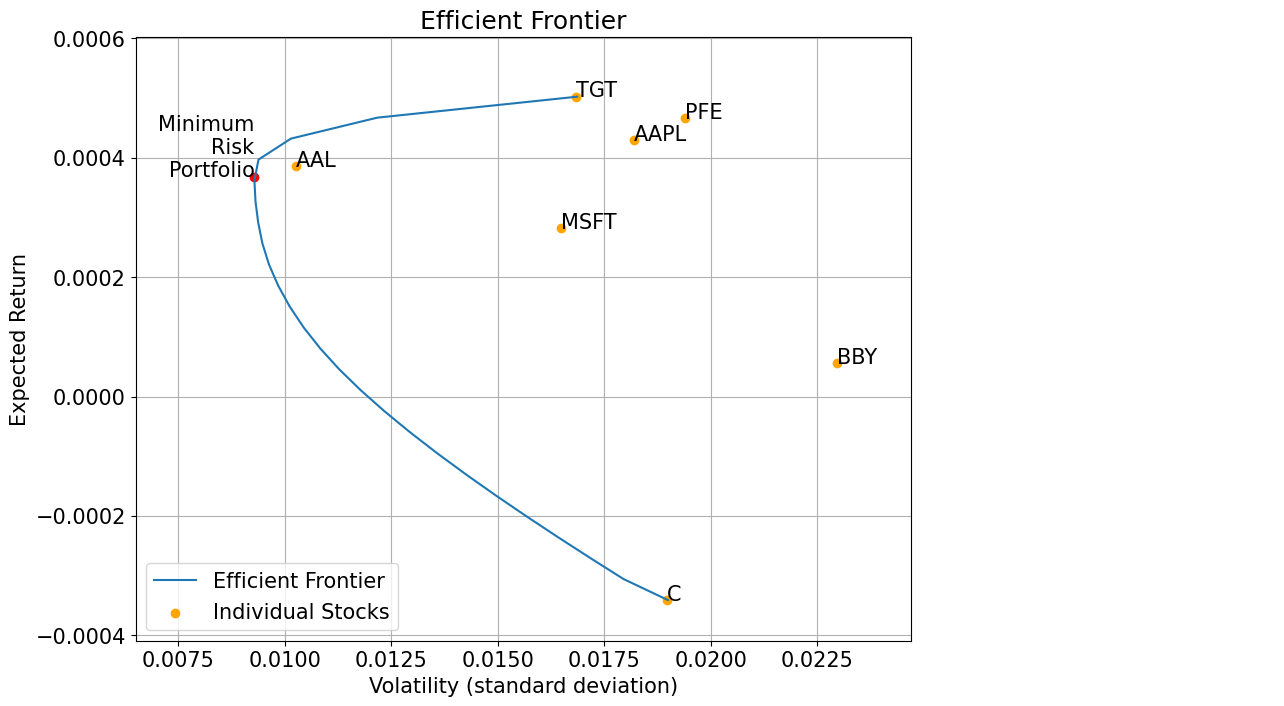

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,8), dpi = 100)

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta, label='Individual Stocks', color = 'orange')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color = 'r')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_title('Efficient Frontier')
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend(loc = 'lower left')
ax.grid()
plt.show()

array([2.86082532e-12, 8.79142819e-11, 1.27439607e-12, 3.51407294e-12,
       1.18844215e-12, 1.55041797e-11, 1.29473409e-12, 4.01972177e-13,
       1.00000000e+00, 2.29306615e-12])

## Objective vs. $\rho$

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving robust.csv to robust (1).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['robust.csv']), header=None)
# Dataset is now stored in a Pandas Dataframe

In [ ]:
df.columns = ["rho", "return", "risk"]

In [ ]:
df2 = df[(df.risk <= 0.14) & (df.risk > 0.05)]

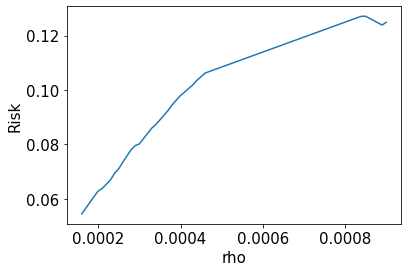

In [ ]:
plt.plot(df2.rho, df2.risk)
plt.xlabel("rho")
plt.ylabel("Risk")
plt.show()

In [ ]:
len(df2)

27

In [ ]:
df2

,rho,return,risk
1,0.00016,0.000400,0.054395
3,0.00019,0.000400,0.060856
4,0.00020,0.000400,0.062819
5,0.00021,0.000400,0.063809
7,0.00023,0.000400,0.066961
8,0.00024,0.000400,0.069422
9,0.00025,0.000400,0.071022
10,0.00026,0.000400,0.073494
11,0.00027,0.000400,0.075769
12,0.00028,0.000400,0.078035


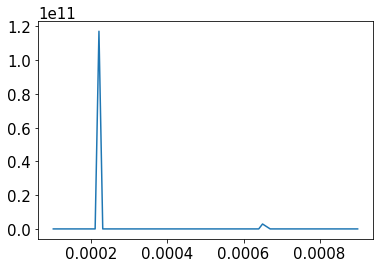

In [ ]:
plt.plot(df.rho, df.risk)